## References:
- https://arxiv.org/pdf/2004.11362.pdf
- https://towardsdatascience.com/contrastive-loss-for-supervised-classification-224ae35692e7

## Initial setup

In [25]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [24]:
!pip install wandb
import wandb
wandb.login()

True

In [3]:
!wget https://raw.githubusercontent.com/wangz10/contrastive_loss/master/losses.py

--2020-05-27 03:45:58--  https://raw.githubusercontent.com/wangz10/contrastive_loss/master/losses.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5169 (5.0K) [text/plain]
Saving to: ‘losses.py’

losses.py           100%[===================>]   5.05K  --.-KB/s    in 0s      

2020-05-27 03:45:58 (84.3 MB/s) - ‘losses.py’ saved [5169/5169]



In [0]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tqdm.notebook import tqdm
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import losses
import cv2
from imutils import paths
tf.random.set_seed(666)
np.random.seed(666)



## Getting the dataset

In [5]:
!git clone https://github.com/thunderInfy/imagenet-5-categories


Cloning into 'imagenet-5-categories'...
remote: Enumerating objects: 1532, done.
remote: Total 1532 (delta 0), reused 0 (delta 0), pack-reused 1532
Receiving objects: 100% (1532/1532), 88.56 MiB | 23.13 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [26]:
# Train and test image paths
train_images = list(paths.list_images("imagenet-5-categories/train"))
test_images = list(paths.list_images("imagenet-5-categories/test"))
print(len(train_images), len(test_images))

1250 250


In [0]:
def prepare_images(image_paths):
    images = []
    labels = []

    for image in tqdm(image_paths):
        image_pixels = plt.imread(image)
        image_pixels = cv2.resize(image_pixels, (128,128))
        image_pixels = image_pixels/255.

        label = image.split("/")[2].split("_")[0]

        images.append(image_pixels)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    print(images.shape, labels.shape)

    return images, labels

In [28]:

X_train, y_train = prepare_images(train_images)
X_test, y_test = prepare_images(test_images)


(1250, 128, 128, 3) (1250,)



(250, 128, 128, 3) (250,)


In [0]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)


In [0]:
train_ds=tf.data.Dataset.from_tensor_slices((X_train,y_train_enc))
validation_ds=tf.data.Dataset.from_tensor_slices((X_test,y_test_enc))

In [0]:
IMG_SHAPE = 128
BS = 64


In [0]:
train_ds = (
    train_ds
    .shuffle(100)
    .batch(BS)
)

In [0]:
validation_ds = (
    validation_ds
    .shuffle(100)
    .batch(BS)
)

## Model building

In [0]:
# Reference: https://github.com/wangz10/contrastive_loss/blob/master/model.py
class UnitNormLayer(tf.keras.layers.Layer):
    '''Normalize vectors (euclidean norm) in batch to unit hypersphere.
    '''
    def __init__(self):
        super(UnitNormLayer, self).__init__()

    def call(self, input_tensor):
        norm = tf.norm(input_tensor, axis=1)
        return input_tensor / tf.reshape(norm, [-1, 1])

In [0]:
# Encoder Network
def encoder_net():
	inputs = Input((IMG_SHAPE, IMG_SHAPE, 3))
	normalization_layer = UnitNormLayer()

	encoder = tf.keras.applications.ResNet50(weights=None, include_top=False)
	encoder.trainable = True

	embeddings = encoder(inputs, training=True)
	embeddings = GlobalAveragePooling2D()(embeddings)
	norm_embeddings = normalization_layer(embeddings)

	encoder_network = Model(inputs, norm_embeddings)

	return encoder_network

# Projector Network
def projector_net():
	projector = tf.keras.models.Sequential([
		Dense(128, activation="relu"),
		UnitNormLayer()
	])

	return projector

## Training the encoder and the projector

In [0]:
decay_steps = 1000
lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate=0.001, decay_steps=decay_steps)
optimizer = tf.keras.optimizers.Adam(lr_decayed_fn)

In [0]:
encoder_r = encoder_net()
projector_z = projector_net()

@tf.function
def train_step(images, labels):
	with tf.GradientTape() as tape:
		r = encoder_r(images, training=True)
		z = projector_z(r, training=True)
		loss = losses.max_margin_contrastive_loss(z, labels, metric='cosine')

	gradients = tape.gradient(loss, 
		encoder_r.trainable_variables + projector_z.trainable_variables)
	optimizer.apply_gradients(zip(gradients, 
		encoder_r.trainable_variables + projector_z.trainable_variables))

	return loss

In [0]:
import os
os.environ['WANDB_DISABLE_CODE'] = 'True'


Epoch: 0 Loss: 0.307
Epoch: 2 Loss: 0.168
Epoch: 4 Loss: 0.154
Epoch: 6 Loss: 0.140
Epoch: 8 Loss: 0.123
Epoch: 10 Loss: 0.115
Epoch: 12 Loss: 0.117
Epoch: 14 Loss: 0.107
Epoch: 16 Loss: 0.105
Epoch: 18 Loss: 0.094
Epoch: 20 Loss: 0.082
Epoch: 22 Loss: 0.078
Epoch: 24 Loss: 0.071
Epoch: 26 Loss: 0.057
Epoch: 28 Loss: 0.048
Epoch: 30 Loss: 0.039
Epoch: 32 Loss: 0.030
Epoch: 34 Loss: 0.020
Epoch: 36 Loss: 0.012
Epoch: 38 Loss: 0.008
Epoch: 40 Loss: 0.010
Epoch: 42 Loss: 0.008
Epoch: 44 Loss: 0.008
Epoch: 46 Loss: 0.008
Epoch: 48 Loss: 0.007
Epoch: 50 Loss: 0.007
Epoch: 52 Loss: 0.006
Epoch: 54 Loss: 0.007
Epoch: 56 Loss: 0.007
Epoch: 58 Loss: 0.007



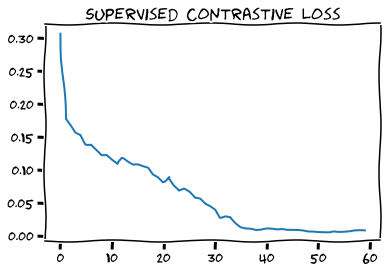

Unable to save ipython session history:
b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x83\x00\x00\x01\x0f\x08\x06\x00\x00\x00\xa0\x16\xa8\xb1\x00\x00\x00\x04sBIT\x08\x08\x08\x08|\x08d\x88\x00\x00\x00\tpHYs\x00\x00\x0b\x12\x00\x00\x0b\x12\x01\xd2\xdd~\xfc\x00\x00\x008tEXtSoftware\x00matplotlib version3.2.1, http://matplotlib.org/\xa3\xf2:\xda\x00\x00 \x00IDATx\x9c\xec\x9dw|S\xd5\x1b\xc6\x9f\xec4i\x9b\xb4\xe9d\x96\x96U\xf6\x12*{\x83\n\x82\xca\x9e\x82\xca\x92)\x88?Q\x04q\x02"  "C\x14\x99"CV-\x1b\xd9 \x1bZ\x10\x90\xa5t\x8fte4y\x7f\x7f\xd4\\\x89M\x9b\x14\nm\xca\xfb\xfd|\xf2\x81\xde{\xce\xb9\xef\xbd\xb9y\x9e{\xc6=GDD\x04\x86a\x18\xe6\xa9F\\\xdc\x010\x0c\xc30\xc5\x0f\x9b\x01\xc30\x0c\xc3f\xc00\x0c\xc3\xb0\x190\x0c\xc30`3`\x18\x86a\xc0f\xc00\x0c\xc3\x80\xcd\x80yBdff\xe2\xe0\xc1\x838s\xe6Lq\x87R\xea\xb1Z\xad8r\xe4\x08\xae\\\xb9\xe2R\xfa{\xf7\xee\xe1\xe0\xc1\x83\xb8u\xeb\xd6\xe3\r\xccM\xb9t\xe9\x12\x0e\x1e<\x88\xd4\xd4T\x87\xfbM&\x13~\xfb\xed7\x1c?~\xfc\tGV\xb4H\x8b;\x80\xa7\x81\x13\'N`\xeb\

In [38]:
import time


wandb.init(project="scl", entity="authors", id="SCLA1")
EPOCHS = 60
LOG_EVERY = 2
train_loss_results = []

start = time.time()
for epoch in tqdm(range(EPOCHS)):	
	epoch_loss_avg = tf.keras.metrics.Mean()
	
	for (images, labels) in train_ds:
		loss = train_step(images, labels)
		epoch_loss_avg.update_state(loss) 

	train_loss_results.append(epoch_loss_avg.result())
	wandb.log({"supervised_contrastive_loss": epoch_loss_avg.result()})

	if epoch % LOG_EVERY == 0:
		print("Epoch: {} Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))
  
end = time.time()
wandb.log({"training_time": end - start})

with plt.xkcd():
    plt.plot(train_loss_results)
    plt.title("Supervised Contrastive Loss")
    plt.show()

## Supervised Model

In [0]:
def supervised_model():
	inputs = Input((IMG_SHAPE, IMG_SHAPE, 3))
	encoder_r.trainable = False

	r = encoder_r(inputs, training=False)
	outputs = Dense(1)(r)

	supervised_model = Model(inputs, outputs)
  
	return supervised_model


In [0]:
from wandb.keras import WandbCallback

In [0]:
optimizer2 = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [0]:
supervised_classifier = supervised_model()

supervised_classifier.compile(optimizer=optimizer2,
	loss=tf.keras.losses.SparseCategoricalCrossentropy(),
	metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2,
	restore_best_weights=True, verbose=2)

wandb.init(project="scl", entity="authors",id='FCLA1')


supervised_classifier.fit(train_ds,
	validation_data=validation_ds,
	epochs=100,
	callbacks=[WandbCallback(),es])

In [0]:
S